In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pylab as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from Preprocessing2 import Signal_process, Stat_process 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from icecream import ic 
from scipy import signal
%matplotlib inline

# Data Load

In [2]:
path = 'D:/Data/CMAPSSData'

train_path_list = sorted(glob(path + '/train*'))
test_path_list = sorted(glob(path + '/test*'))
rul_path_list = sorted(glob(path + '/RUL*'))

In [3]:
col_name = ['unit number', 'time', 'op1', 'op2', 'op3']
temp = ['sensor %d'%(i+1) for i in range(23)]

load_col_name = col_name + temp
col_name = load_col_name[:-2]

In [4]:
train = []
for t_path in train_path_list:
    temp = pd.read_table(t_path, sep = ' ', header = None, names=load_col_name)
    train.append(temp[col_name])

test = []
for t_path in test_path_list:
    temp = pd.read_table(t_path, sep = ' ', header = None, names=load_col_name)
    test.append(temp[col_name])
    
RUL = []
for r_path in rul_path_list:
    temp = pd.read_table(r_path, header = None, names = ['RUL'])
    RUL.append(temp)

# Seperate unit number, time and sensor datas

In [5]:
train_index = []
for key, value in enumerate(train):
    train_index.append(train[key][['unit number', 'time']])
    train[key] = train[key].drop(['unit number', 'time'], axis = 1)

In [6]:
for D in train_index:
    print(D.groupby('unit number').max().min())
    print(D.groupby('unit number').max().max())
    print('\n')

time    128
dtype: int64
time    362
dtype: int64


time    128
dtype: int64
time    378
dtype: int64


time    145
dtype: int64
time    525
dtype: int64


time    128
dtype: int64
time    543
dtype: int64




# Normalize(optional)

In [7]:
#SCALE = 'None' # MINMAX, STANDARD

def NORM(train, SCALE):
    if SCALE == 'MINMAX':
        scaler_norm = []
        for key, values in enumerate(train):
            scaler_norm_ = MinMaxScaler().fit(values)
            scaler_norm.append(scaler_norm_)
            train[key] = scaler_norm_.transform(values)
            train[key] = pd.DataFrame(train[key], columns = col_name[2:])

    if SCALE == 'STANDARD':
        scaler_norm = []
        for key, values in enumerate(train):
            scaler_norm_ = StandardScaler().fit(values)
            scaler_norm.append(scaler_norm_)
            train[key] = scaler_norm_.transform(values)
            train[key] = pd.DataFrame(train[key], columns = col_name[2:])
    
    return train

# Statistic name extraction

In [8]:
stat = Stat_process()
select = [stat.RMS, stat.Crest, stat.Shape, stat.p2p, stat.Impulse, stat.Margin, stat.waveform_Entropy, stat.get_median_absolute_deviation, stat.skew, stat.kurt]

statistic_name = 'stat.RMS, stat.Crest, stat.Shape, stat.p2p, stat.Impulse, stat.Margin, stat.waveform_Entropy, stat.get_median_absolute_deviation, stat.skew, stat.kurt'
statistic_name = statistic_name.replace(" ","")
statistic_name = statistic_name.replace('stat.',"")
statistic_name = statistic_name.split(',')

In [9]:
statistic_name

['RMS',
 'Crest',
 'Shape',
 'p2p',
 'Impulse',
 'Margin',
 'waveform_Entropy',
 'get_median_absolute_deviation',
 'skew',
 'kurt']

# signal resampling effect check

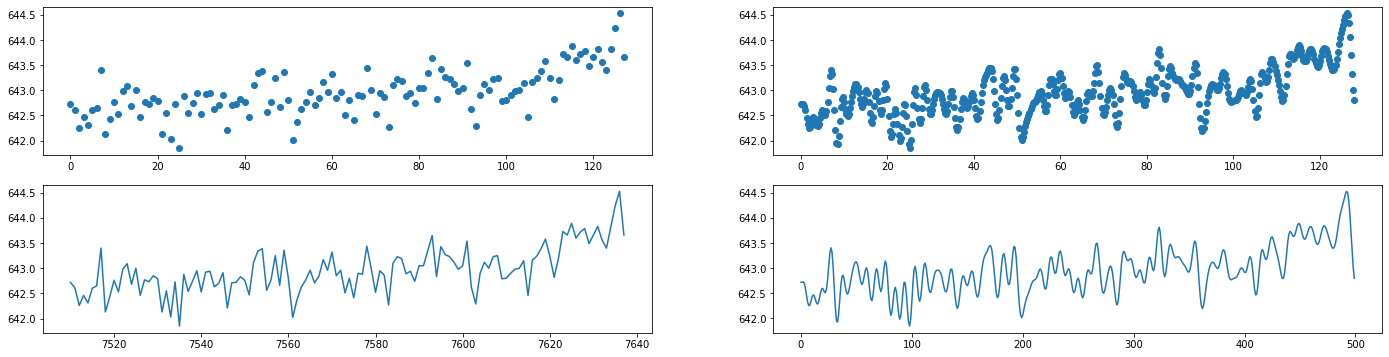

In [10]:
#unit number 39 length = 128(minimum value)
target_length = 500

unit_number39 = train_index[0].groupby('unit number').get_group(39)

time1 = np.arange(len(unit_number39))
time2 = np.linspace(0,len(unit_number39), target_length)

unit_number39_sensor2 = train[0].loc[unit_number39.index]['sensor 2']
unit_number39_sensor2_resample = signal.resample(unit_number39_sensor2, target_length)

fig, ax = plt.subplots(2,2, figsize = (24,6))

ax[0,0].scatter(time1, unit_number39_sensor2)
ax[0,1].scatter(time2, unit_number39_sensor2_resample)
ax[1,0].plot(unit_number39_sensor2)
ax[1,1].plot(unit_number39_sensor2_resample)
plt.show()

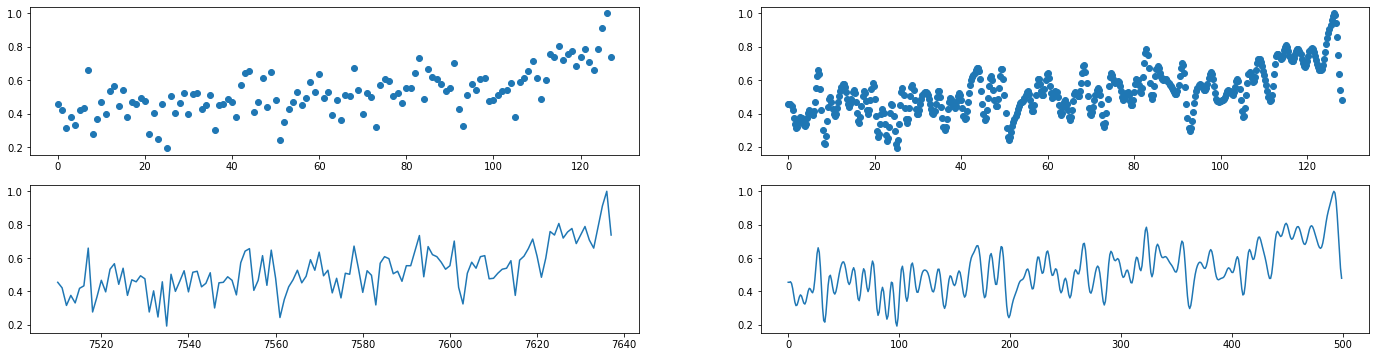

In [11]:
#unit number 39 length = 128(minimum value)
minmax_train = NORM(train, SCALE = 'MINMAX')
target_length = 500

unit_number39 = train_index[0].groupby('unit number').get_group(39)

time1 = np.arange(len(unit_number39))
time2 = np.linspace(0,len(unit_number39), target_length)

unit_number39_sensor2 = minmax_train[0].loc[unit_number39.index]['sensor 2']
unit_number39_sensor2_resample = signal.resample(unit_number39_sensor2, target_length)

fig, ax = plt.subplots(2,2, figsize = (24,6))

ax[0,0].scatter(time1, unit_number39_sensor2)
ax[0,1].scatter(time2, unit_number39_sensor2_resample)
ax[1,0].plot(unit_number39_sensor2)
ax[1,1].plot(unit_number39_sensor2_resample)
plt.show()

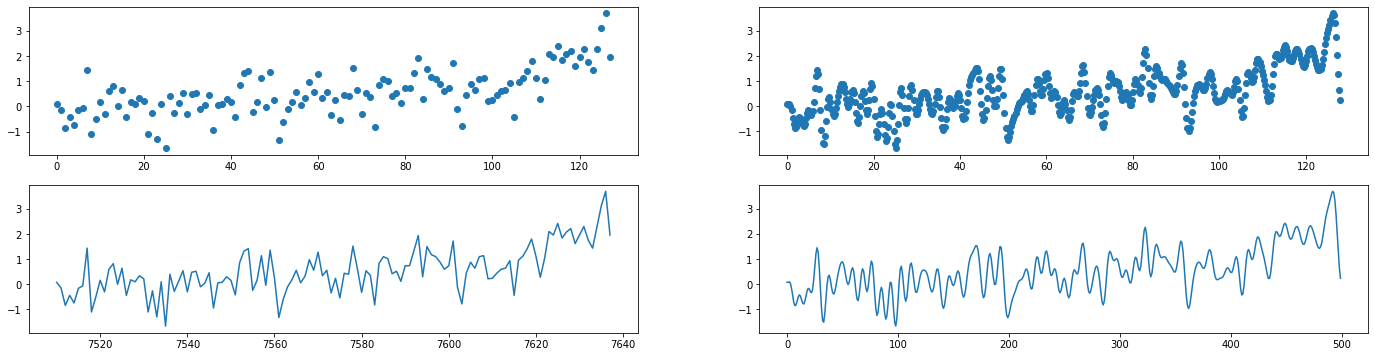

In [12]:
#unit number 39 length = 128(minimum value)
standard_train = NORM(train, SCALE = 'STANDARD')
target_length = 500

unit_number39 = train_index[0].groupby('unit number').get_group(39)

time1 = np.arange(len(unit_number39))
time2 = np.linspace(0,len(unit_number39), target_length)

unit_number39_sensor2 = standard_train[0].loc[unit_number39.index]['sensor 2']
unit_number39_sensor2_resample = signal.resample(unit_number39_sensor2, target_length)

fig, ax = plt.subplots(2,2, figsize = (24,6))

ax[0,0].scatter(time1, unit_number39_sensor2)
ax[0,1].scatter(time2, unit_number39_sensor2_resample)
ax[1,0].plot(unit_number39_sensor2)
ax[1,1].plot(unit_number39_sensor2_resample)
plt.show()

In [13]:
unit_number39_data = train[0].loc[unit_number39.index]

unit_number39_resample = signal.resample(unit_number39_data, target_length)

non_resample = stat.Concat(unit_number39_data, select = select)
resampling = stat.Concat(unit_number39_resample, select = select)
                           
non_resample = pd.DataFrame(non_resample.reshape(-1,24), columns = col_name[2:], index = statistic_name)
resampling = pd.DataFrame(resampling.reshape(-1,24), columns = col_name[2:], index = statistic_name)

C:\Users\HYKP\PycharmProjects\bistel\CMAPSS\Preprocessing2.py:90: RuntimeWarning: invalid value encountered in true_divide
  return crest / rms
C:\Users\HYKP\PycharmProjects\bistel\CMAPSS\Preprocessing2.py:97: RuntimeWarning: invalid value encountered in true_divide
  return rms / mean
C:\Users\HYKP\PycharmProjects\bistel\CMAPSS\Preprocessing2.py:110: RuntimeWarning: invalid value encountered in true_divide
  return p2p / mean
C:\Users\HYKP\PycharmProjects\bistel\CMAPSS\Preprocessing2.py:117: RuntimeWarning: invalid value encountered in true_divide
  return p2p / cif


In [14]:
display(non_resample)
display(resampling)

,op1,op2,op3,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,sensor 6,sensor 7,...,sensor 12,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21
RMS,1.048176,1.034289,0.0,0.0,1.066936,0.978673,1.018107,0.0,0.141683,1.008429,...,1.066228,1.296319,1.138520,0.985494,0.0,0.846560,0.0,0.0,0.907711,0.923043
Crest,3.180242,1.971766,NaN,NaN,3.465839,2.587707,3.017039,NaN,1.000000,3.941275,...,3.285266,2.615617,1.746137,2.601575,NaN,2.890228,NaN,NaN,3.207764,2.618207
Shape,13.022063,3.055120,NaN,NaN,1.925791,2.645458,1.799422,NaN,1.000000,-1.687578,...,-1.709693,1.313861,-1.036218,1.953085,NaN,2.795299,NaN,NaN,-2.332634,-2.119784
p2p,6.263543,3.412328,0.0,0.0,5.359559,4.089055,4.200931,0.0,0.000000,4.790577,...,4.501478,3.754319,1.438478,3.778251,0.0,3.874153,0.0,0.0,4.536852,4.014845
Impulse,77.815422,10.079460,NaN,NaN,9.673861,11.053152,7.424804,NaN,0.000000,-8.016895,...,-7.218107,3.805122,-1.309225,7.487866,NaN,12.792260,NaN,NaN,-11.658796,-9.220162
Margin,4.999734,2.832923,NaN,NaN,5.460669,4.029797,4.968591,NaN,0.000000,6.671209,...,5.605797,3.875810,1.332694,4.083580,NaN,3.987761,NaN,NaN,5.088284,4.336254
waveform_Entropy,3.679404,1.338690,NaN,NaN,4.307881,2.460320,3.331644,NaN,0.000000,5.405476,...,3.907651,2.514915,0.973307,2.487409,NaN,3.067500,NaN,NaN,3.738886,2.519996
get_median_absolute_deviation,0.662930,0.682466,0.0,0.0,0.559954,0.606752,0.550532,0.0,0.000000,0.519732,...,0.481333,0.556195,0.160676,0.533275,0.0,0.645692,0.0,0.0,0.553275,0.494696
skew,-0.179279,-0.059597,0.0,0.0,0.436533,0.459156,0.684564,0.0,0.000000,-1.008900,...,-0.905624,0.877020,-0.765022,0.423350,0.0,0.168488,0.0,0.0,-0.266930,-0.269767
kurt,0.612616,-1.085208,-3.0,-3.0,0.591164,-0.325096,-0.042539,-3.0,-3.000000,1.738825,...,0.544623,0.450957,0.296792,-0.099051,-3.0,-0.022794,-3.0,-3.0,-0.019372,-0.048352


,op1,op2,op3,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,sensor 6,sensor 7,...,sensor 12,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21
RMS,1.042897,1.026779,0.0,0.0,1.066830,0.977874,1.017615,0.0,1.416833e-01,1.007948,...,1.065352,1.295630,1.138503,0.985471,0.0,0.845650,0.0,0.0,0.907701,0.922612
Crest,3.285526,2.189933,NaN,NaN,3.463378,2.747992,3.018369,NaN,1.000000e+00,3.895312,...,3.719742,2.789837,1.907798,2.617695,NaN,2.898610,NaN,NaN,3.197839,2.631770
Shape,12.956477,3.032936,NaN,NaN,1.925600,2.643296,1.798553,NaN,1.000000e+00,-1.686773,...,-1.708288,1.313163,-1.036204,1.953040,NaN,2.792295,NaN,NaN,-2.332608,-2.118795
p2p,6.543276,4.195541,0.0,0.0,5.357501,4.232943,4.204619,0.0,0.000000e+00,4.924157,...,5.116588,4.018620,1.711954,4.267339,0.0,4.353604,0.0,0.0,4.582035,4.322587
Impulse,81.290694,12.392942,NaN,NaN,9.670146,11.442096,7.431323,NaN,0.000000e+00,-8.240437,...,-8.204434,4.073000,-1.558127,8.457158,NaN,14.375380,NaN,NaN,-11.774907,-9.926895
Margin,5.117774,2.952822,NaN,NaN,5.353653,4.188981,4.902604,NaN,0.000000e+00,6.498681,...,6.492748,4.249367,1.585936,4.177635,NaN,4.377931,NaN,NaN,4.996653,4.171435
waveform_Entropy,3.908222,1.716625,NaN,NaN,4.302361,2.777865,3.334442,NaN,3.330669e-15,5.296742,...,4.886454,2.862325,1.232341,2.518993,NaN,3.084792,NaN,NaN,3.717408,2.546649
get_median_absolute_deviation,0.670986,0.752185,0.0,0.0,0.584471,0.652013,0.546301,0.0,0.000000e+00,0.489037,...,0.493115,0.517034,0.164837,0.544682,0.0,0.500993,0.0,0.0,0.550446,0.528272
skew,-0.146108,-0.130082,0.0,0.0,0.469636,0.403538,0.698149,0.0,-1.000000e+00,-1.017327,...,-0.924702,0.863282,-0.810773,0.440071,0.0,0.186746,0.0,0.0,-0.284458,-0.217886
kurt,0.408410,-0.903753,-3.0,-3.0,0.487124,-0.470266,-0.042176,-3.0,-2.000000e+00,1.532397,...,0.723289,0.428104,0.511098,-0.097341,-3.0,-0.027870,-3.0,-3.0,-0.161166,-0.168049


# Variance Check

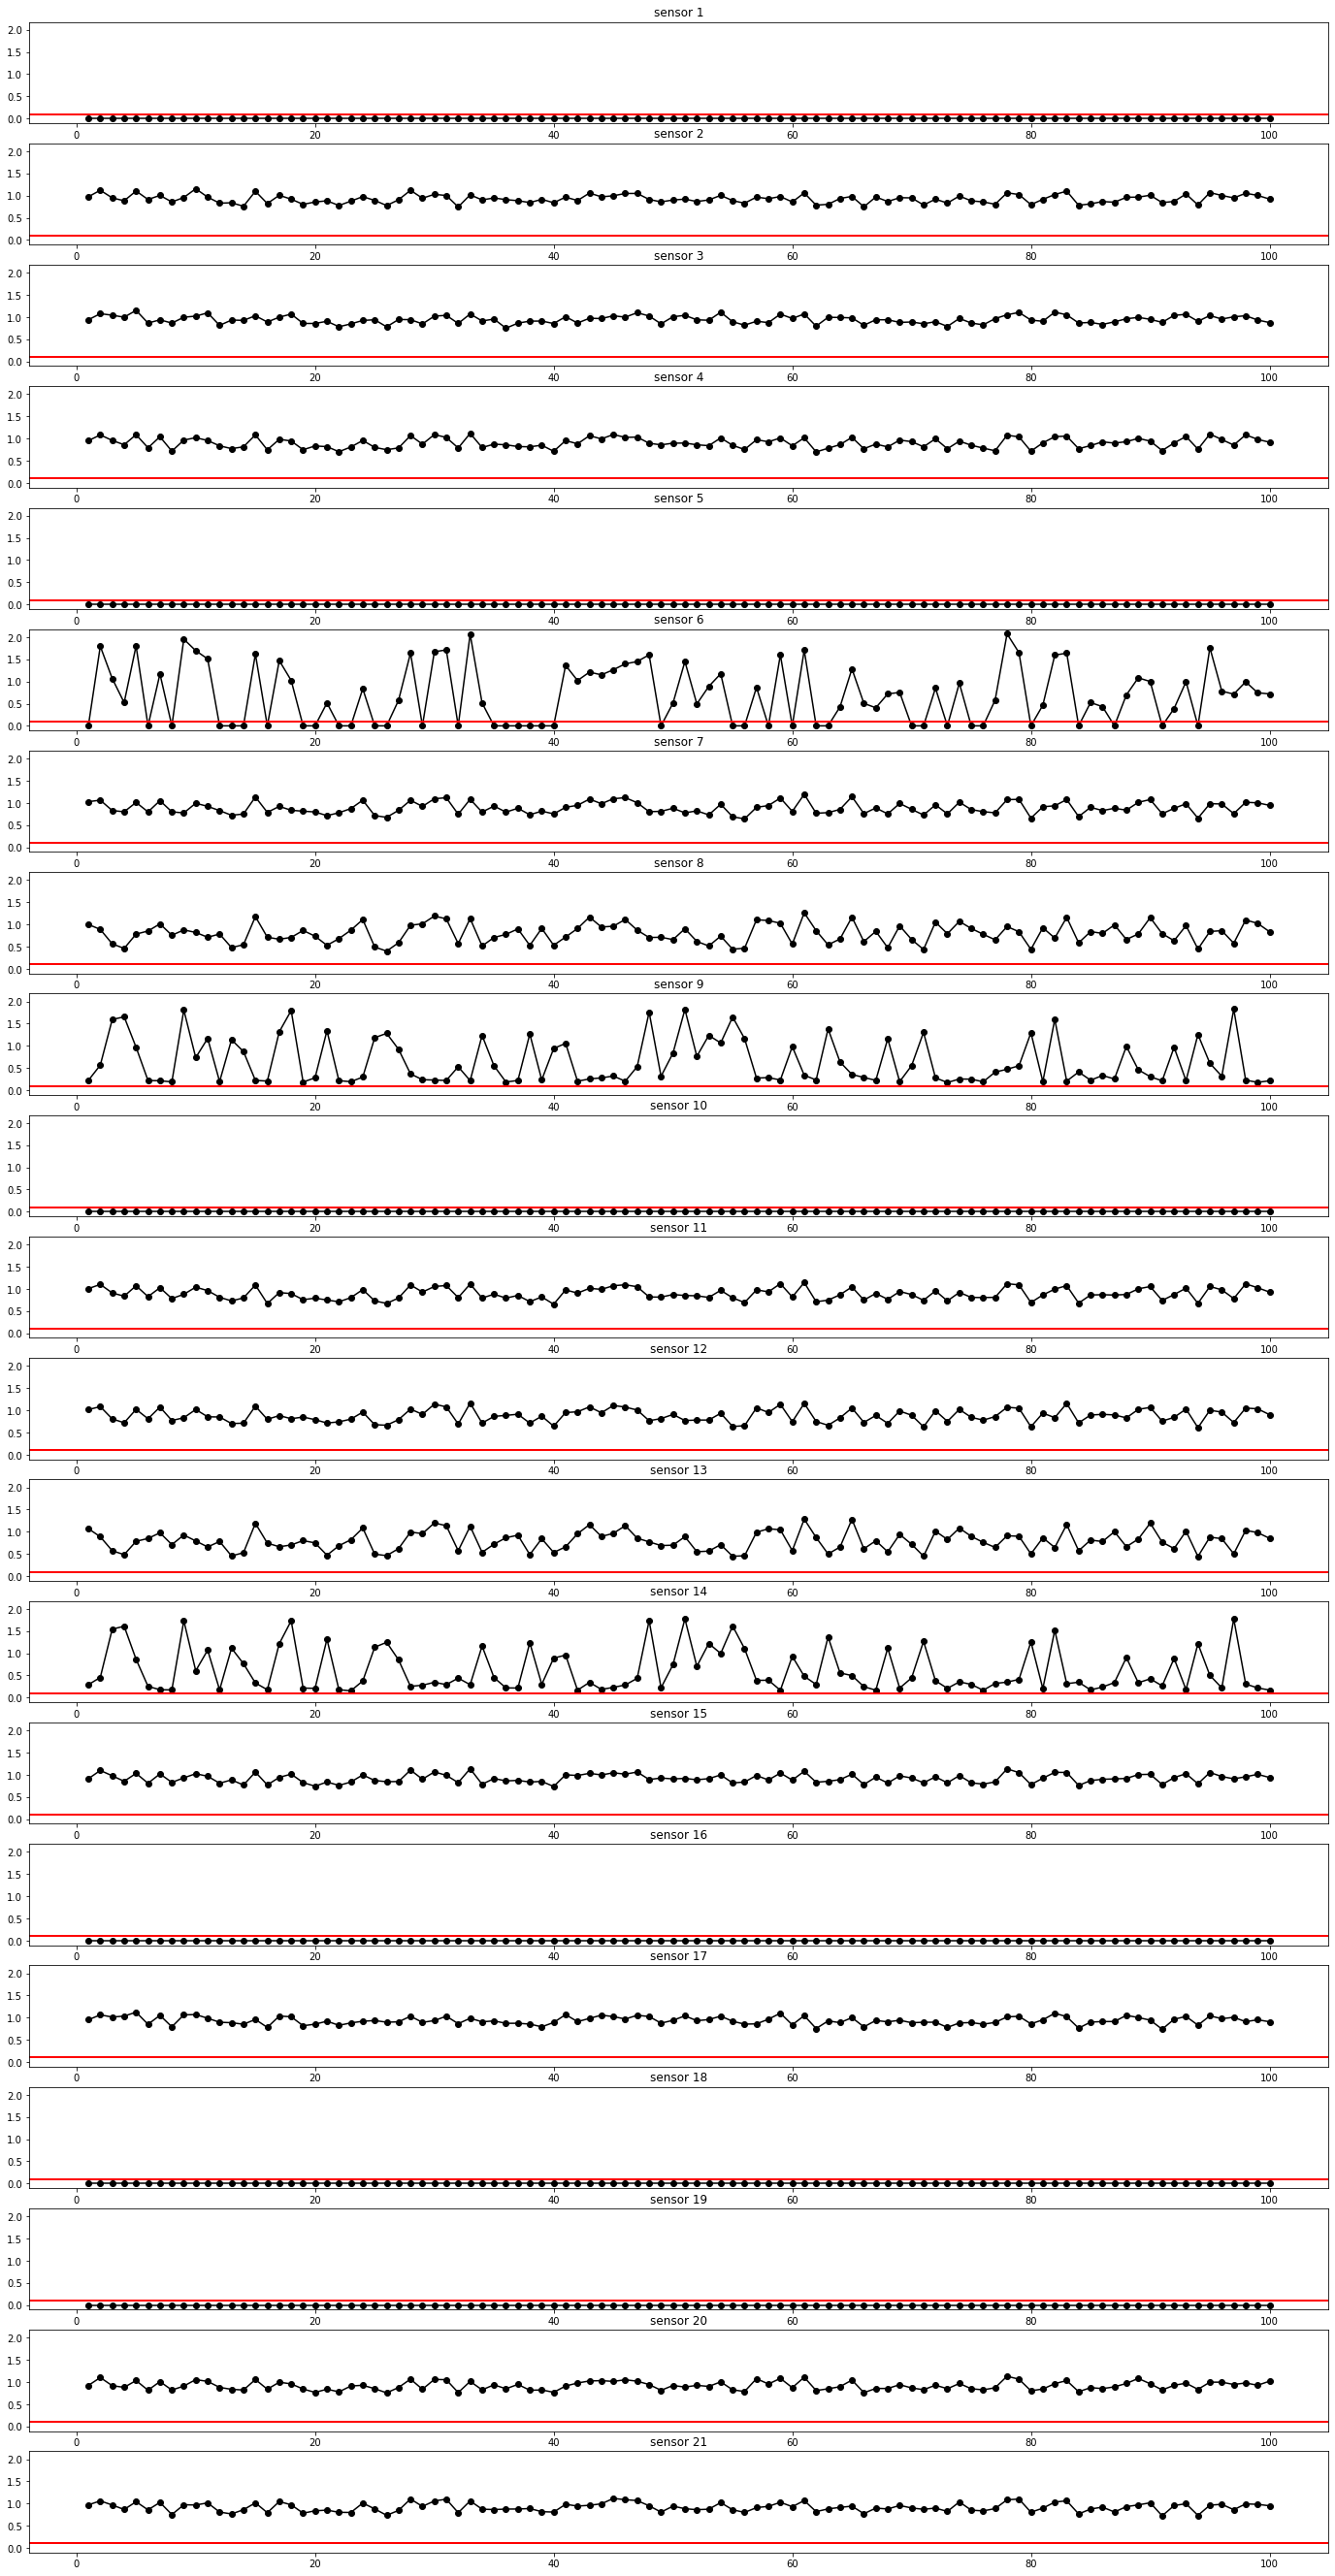

In [15]:
train_ = pd.concat([train_index[0], minmax_train[0]], axis = 1)

variance_check = train_.groupby('unit number').std()

N = len(col_name)
fig, ax = plt.subplots(21,1, figsize = (24, 48), sharey=True)
for key, name in enumerate(col_name[5:]):
    #fig, ax = plt.subplots(1,1, figsize = (24, 1), sharey=True)
    ax[key].plot(variance_check[name], '-ok')
    ax[key].set_title(f'{name}')
    ax[key].axhline(0.1, color = 'r', linewidth = 2)
plt.show()

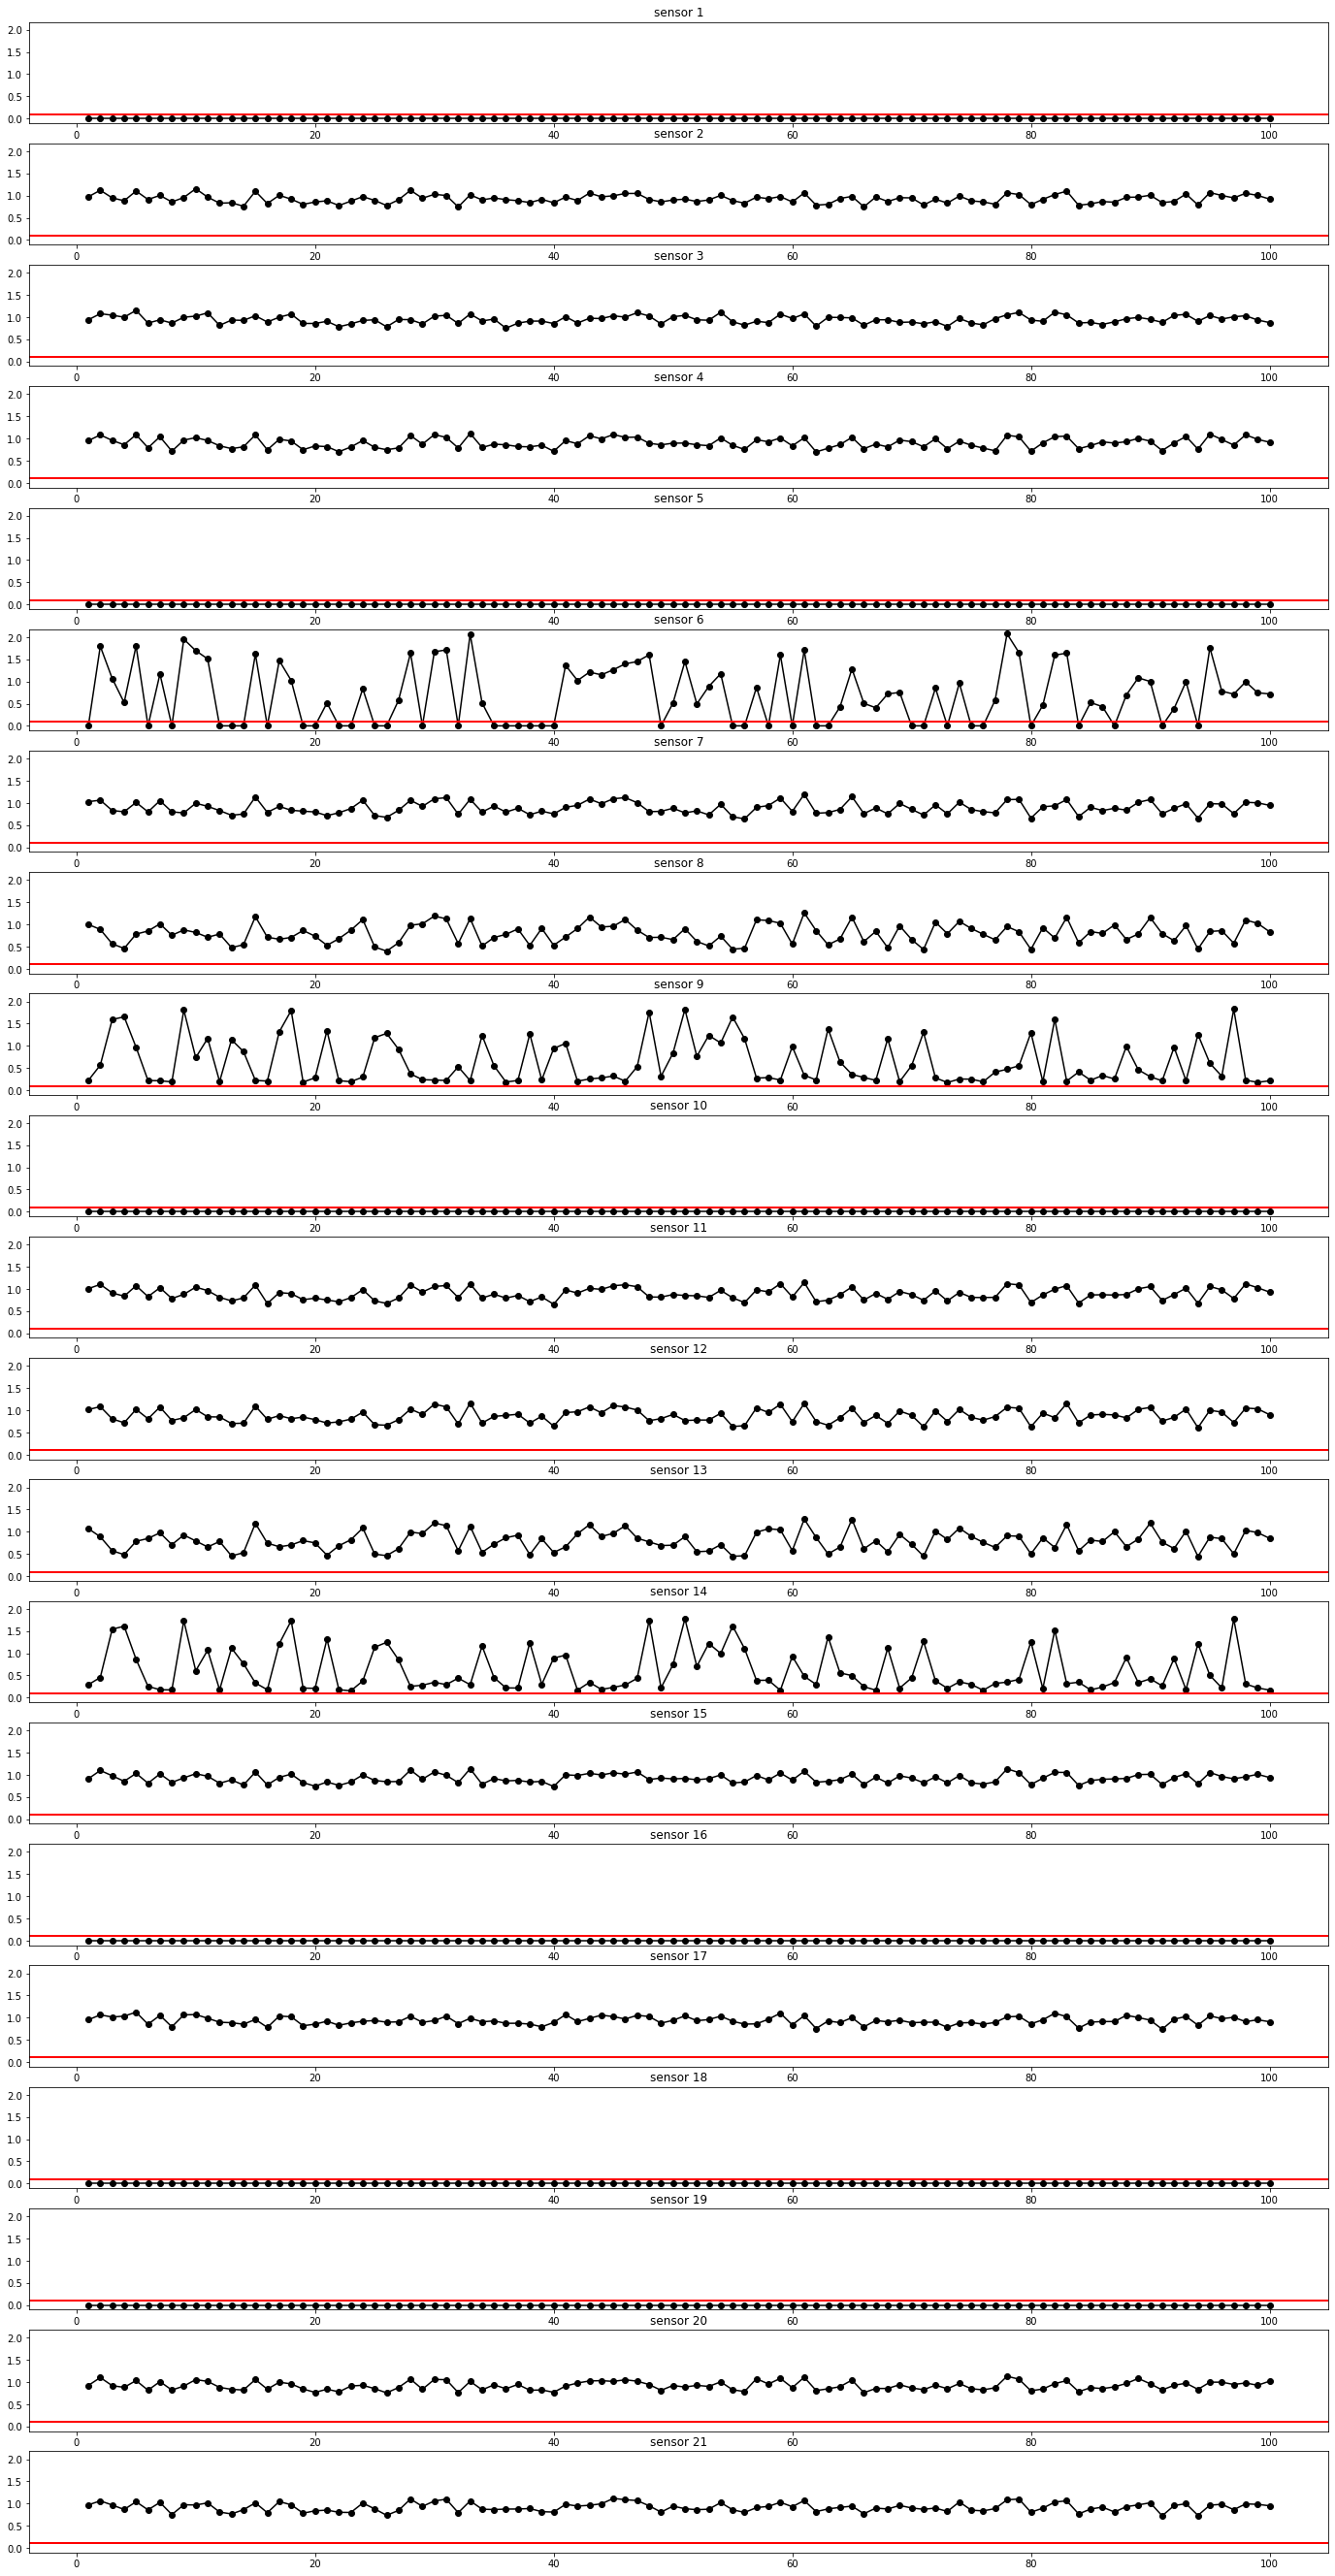

In [319]:
train_ = pd.concat([train_index[0], standard_train[0]], axis = 1)

variance_check = train_.groupby('unit number').std()

N = len(col_name)
fig, ax = plt.subplots(21,1, figsize = (24, 48), sharey=True)
for key, name in enumerate(col_name[5:]):
    #fig, ax = plt.subplots(1,1, figsize = (24, 1), sharey=True)
    ax[key].plot(variance_check[name], '-ok')
    ax[key].set_title(f'{name}')
    ax[key].axhline(0.1, color = 'r', linewidth = 2)
plt.show()

In [16]:
train_ = pd.concat([train_index[0], train[0]], axis = 1)

variance_check = train_.groupby('unit number').std()
bol = variance_check > 0.1
selected_idx = np.where(bol.sum(axis=0) == 100)[0] + 1
selected_col = [col_name[index] for index in selected_idx]
selected_col[3:]

['sensor 2',
 'sensor 3',
 'sensor 4',
 'sensor 7',
 'sensor 8',
 'sensor 9',
 'sensor 11',
 'sensor 12',
 'sensor 13',
 'sensor 14',
 'sensor 15',
 'sensor 17',
 'sensor 20',
 'sensor 21']

In [235]:
# train_ = pd.concat([train_index[0], train[0]], axis = 1)

# variance_check = train_.groupby('unit number').std()
# bol = variance_check > 0.1
# select_index = np.where(bol.sum(axis = 0) == 100)[0] + 1
# selected_col = [col_name[index] for index in select_index]
# selected_col = selected_col[3:-2]
# train_[selected_col]

# bol.sum(axis = 0)

# Feature Extraction - Statistic 

In [19]:
selected_col[1:]

['op1',
 'op2',
 'sensor 2',
 'sensor 3',
 'sensor 4',
 'sensor 7',
 'sensor 8',
 'sensor 9',
 'sensor 11',
 'sensor 12',
 'sensor 13',
 'sensor 14',
 'sensor 15',
 'sensor 17',
 'sensor 20',
 'sensor 21']

In [22]:
new_train = []
train_len = []
for D in train_index:
    temp = D.groupby('unit number').max()
    train_len.append(len(temp))
    new_train.append(np.zeros(shape = [len(temp), target_length, len(selected_col[1:])]))

In [25]:
train[0]

,op1,op2,op3,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,sensor 6,sensor 7,...,sensor 12,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21
0,-0.315980,-1.372953,0.0,0.0,-1.721725,-0.134255,-0.925936,0.0,0.141683,1.121141,...,0.334262,-1.058890,-0.269071,-0.603816,0.0,-0.781710,0.0,0.0,1.348493,1.194427
1,0.872722,-1.031720,0.0,0.0,-1.061780,0.211528,-0.643726,0.0,0.141683,0.431930,...,1.174899,-0.363646,-0.642845,-0.275852,0.0,-0.781710,0.0,0.0,1.016528,1.236922
2,-1.961874,1.015677,0.0,0.0,-0.661813,-0.413166,-0.525953,0.0,0.141683,1.008155,...,1.364721,-0.919841,-0.551629,-0.649144,0.0,-2.073094,0.0,0.0,0.739891,0.503423
3,0.324090,-0.008022,0.0,0.0,-0.661813,-1.261314,-0.784831,0.0,0.141683,1.222827,...,1.961302,-0.224597,-0.520176,-1.971665,0.0,-0.781710,0.0,0.0,0.352598,0.777792
4,-0.864611,-0.690488,0.0,0.0,-0.621816,-1.251528,-0.301518,0.0,0.141683,0.714393,...,1.052871,-0.780793,-0.521748,-0.339845,0.0,-0.136018,0.0,0.0,0.463253,1.059552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,-0.178822,-1.031720,0.0,0.0,1.618000,1.216258,2.188375,0.0,0.141683,-2.189329,...,-2.607969,2.278282,-0.322542,1.425294,0.0,2.446751,0.0,0.0,-1.805173,-2.921113
20627,-0.727453,-1.714186,0.0,0.0,1.717992,2.279706,2.738351,0.0,0.141683,-2.833345,...,-2.350355,1.722087,-0.380207,1.913240,0.0,1.155367,0.0,0.0,-2.856395,-1.203764
20628,0.186933,-0.008022,0.0,0.0,1.478011,1.946971,2.138377,0.0,0.141683,-2.742957,...,-1.902919,2.000184,-0.141684,3.265092,0.0,3.092444,0.0,0.0,-2.081810,-3.292481
20629,-0.498857,1.015677,0.0,0.0,1.098043,2.403666,1.955051,0.0,0.141683,-3.036719,...,-2.363913,1.861136,-0.233948,2.579834,0.0,1.155367,0.0,0.0,-2.911722,-2.085072


In [27]:
for key, values in enumerate(train_index):
    for i in range(train_len[key]):
        unit_index = values.groupby('unit number').get_group(i+1).index

        new_train[key][i] = signal.resample(train[key][selected_col[1:]].loc[unit_index], target_length)

In [28]:
new_train[0].shape

(100, 500, 16)

In [29]:
int(500/10)


50

In [174]:
# '''
# numpy shape:
# (# of data, statistic, sensor)
# '''
# window_size = 10
# statistic = []
# for key, values in enumerate(new_train):
#     temp = []
#     for i in tqdm(range(train_len[key])):
#         tem = stat.Concat(new_train[key][i], select = select).reshape(1,len(statistic_name), len(col_name[2:]))
#         #tem = pd.DataFrame(tem, columns = col_name[2:], index = statistic_name)
#         temp.append(tem)
#     temp = np.concatenate(temp)
#     statistic.append(temp)

100%|███████████████████████████████████████████████████████████████████████████████| 249/249 [00:00<00:00, 772.96it/s]


In [183]:
new_train[0][0][:10].shape

(10, 24)

In [196]:
'''
numpy shape:
(# of data, window_size, statistic, sensor)
'''
window_size = 10
statistic = []
for key, values in enumerate(new_train):
    statistic_temp = []
    for i in tqdm(range(train_len[key])):
        temp = []
        for j in range(int(500/window_size)):
            tem = stat.Concat(new_train[key][i][window_size*j:window_size*(j+1)], select = select).reshape(1,1, len(statistic_name), len(col_name[2:]))
            temp.append(tem)
        temp = np.concatenate(temp, axis = 1)
        statistic_temp.append(temp)
    statistic_temp = np.concatenate(statistic_temp)
    statistic.append(statistic_temp)

100%|████████████████████████████████████████████████████████████████████████████████| 249/249 [00:06<00:00, 36.80it/s]


In [197]:
statistic[0].shape

(100, 50, 10, 24)

[]

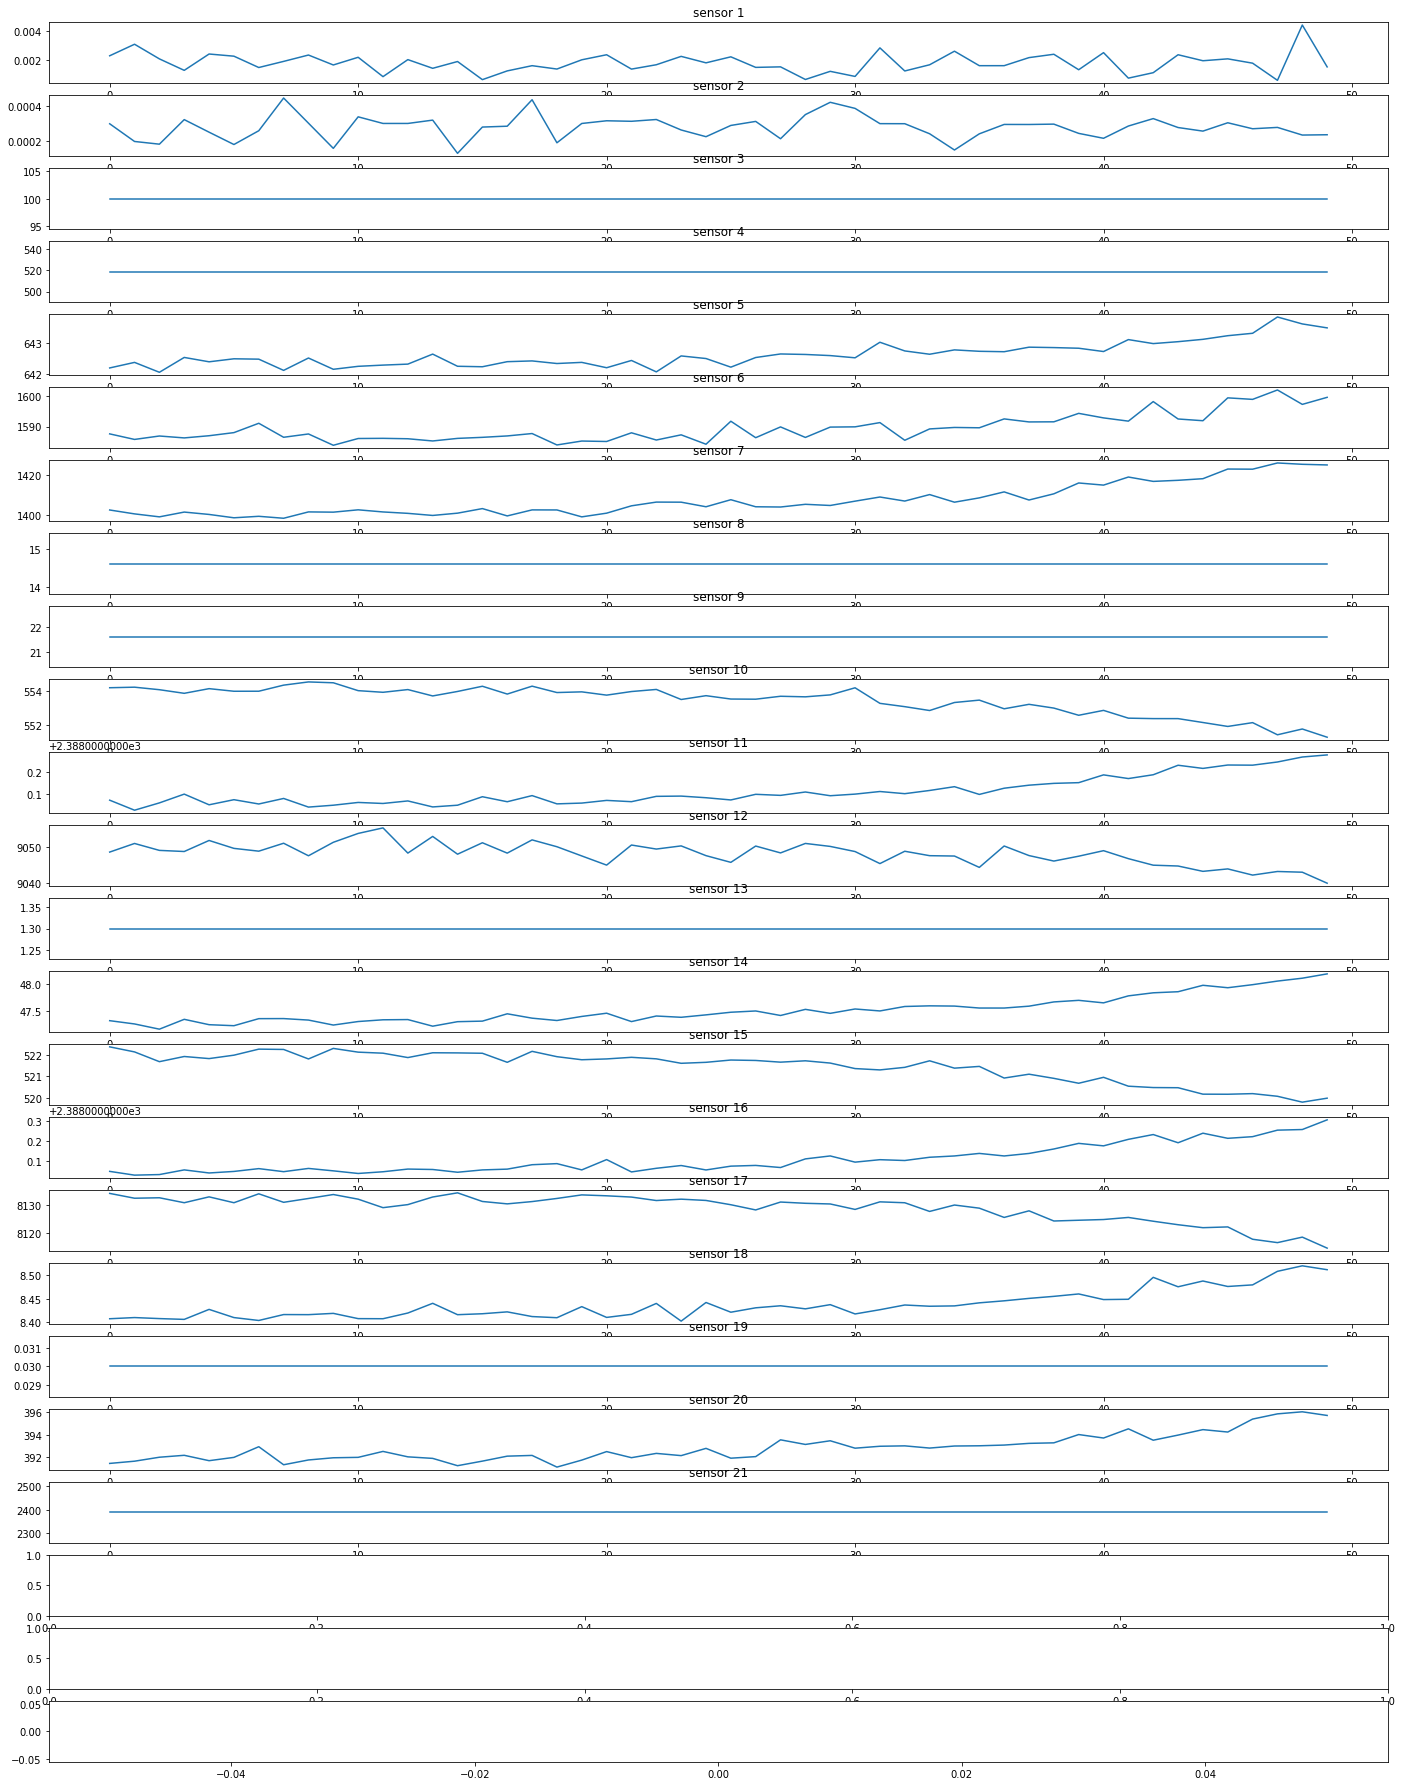

In [332]:
fig, ax = plt.subplots(24,1, figsize=(24,32))
for key, name in enumerate(col_name[5:]):
    ax[key].plot(statistic[0][0,:,0,key])
    ax[key].set_title(f"{name}")
plt.plot()